In [235]:
import pandas
import numpy as np

from clean import *

df_players_teams = pandas.read_csv("dataset/players_teams.csv")

df_players_teams = clean_teams_players(df_players_teams)

df_players_teams.head()

df_players= pandas.read_csv("dataset/players.csv")

df_players = clean_players(df_players)

df_merged = merge_player_info(df_players, df_players_teams) 

df_merged.head()



,playerID,year,stint,tmID,TotalGP,Points,TotalMinutes,TotaloRebounds,TotaldRebounds,TotalRebounds,...,TotalfgMade,TotalftAttempted,TotalftMade,TotalthreeAttempted,TotalthreeMade,TotalGS,TotalDQ,pos,height,weight
0,abrossv01w,2,0,MIN,26,343,846,43,131,174,...,114,132,96,76,19,23,2,F,74.0,169
1,abrossv01w,3,0,MIN,27,314,805,45,101,146,...,119,116,56,60,20,27,0,F,74.0,169
2,abrossv01w,4,0,MIN,33,341,861,45,101,146,...,118,106,77,89,28,28,0,F,74.0,169
3,abrossv01w,5,0,MIN,24,166,529,20,63,83,...,57,50,30,61,22,13,0,F,74.0,169
4,abrossv01w,6,0,MIN,31,304,777,29,78,107,...,109,73,53,82,33,31,0,F,74.0,169


c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


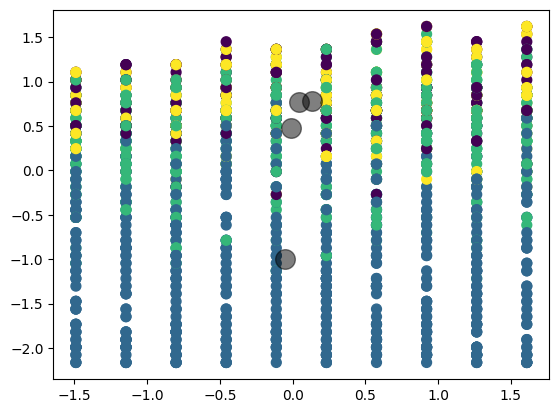

In [236]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# collumn tmID and stint should be dropped
df_players_teams = df_players_teams.drop(['tmID', 'stint'], axis=1)


X, Y = df_players_teams.iloc[:, 1:].values, df_players_teams.iloc[:, 0].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 4  # Number of clusters to create
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# graphic that shows the clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()


In [237]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline

def outliers_pipeline(X_):

    steps = [('scale', StandardScaler()),
             ('LOF', LocalOutlierFactor())
             ]
    outliers = Pipeline(steps).fit_predict(X_)

    return outliers

outliers = outliers_pipeline(X)

df_merged['outliers'] = outliers


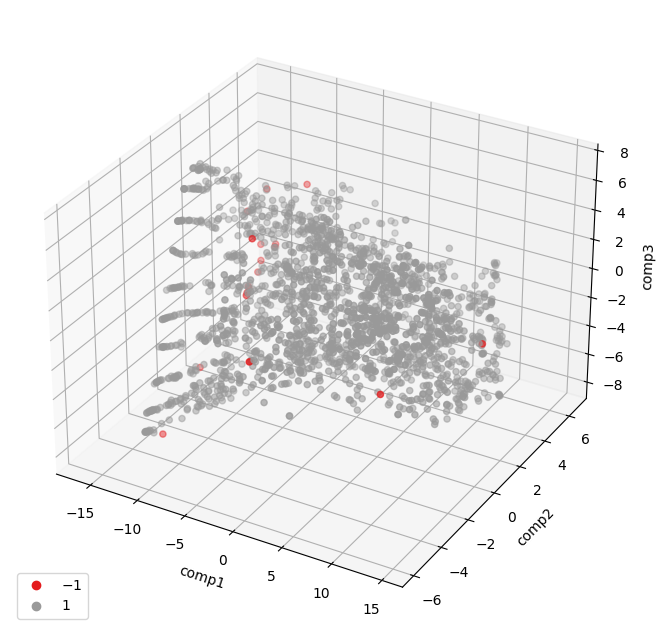

In [238]:
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

def print_outliers_plot(X_scaled, outliers, perp=50):

    tsne = TSNE(perplexity=perp, n_components=3).fit_transform(X_scaled) # we need a good perplexity value to separate the groups
    tsne = pandas.DataFrame(tsne, columns=['comp1', 'comp2', 'comp3'])
    tsne['outliers'] = outliers

    fig = plt.figure(figsize=(8, 8))  # create a new figure
    ax = fig.add_subplot(111, projection='3d')  # create a 3D subplot
    scatter = ax.scatter(tsne['comp1'], tsne['comp2'], tsne['comp3'],
                         c=tsne['outliers'], cmap='Set1')  # create 3D scatter plot
    #
    # add labels and legend
    ax.set_xlabel('comp1')
    ax.set_ylabel('comp2')
    ax.set_zlabel('comp3')
    plt.legend(*scatter.legend_elements(), loc='lower left')

    plt.show()  # display the plot

    return

print_outliers_plot(X_scaled, outliers)


In [239]:

df_best_and_worst = df_merged[df_merged['outliers'] == -1]
df_best_and_worst = df_best_and_worst.drop(['outliers'], axis=1)

# drop where stint != 0 ... as it skews the data
df_best_and_worst = df_best_and_worst[df_best_and_worst['stint'] == 0]

# show all uniques names
b_w_players = df_best_and_worst['playerID'].unique()

print(b_w_players)

['atkinla01w' 'catchta01w' 'chriska01w' 'clinest01w' 'coopecy01w'
 'crockwi01w' 'hornbal01w' 'payeka01w' 'scottol01w' 'stepama01w'
 'terryka01w' 'timmsmi01w' 'walkeay01w']


# TODO ... make this for every type of position / taking in case the defensive and ofensive statistics



0        F
8        C
9        G
14     F-G
46     G-F
98     F-C
455    C-F
Name: pos, dtype: object
position: F


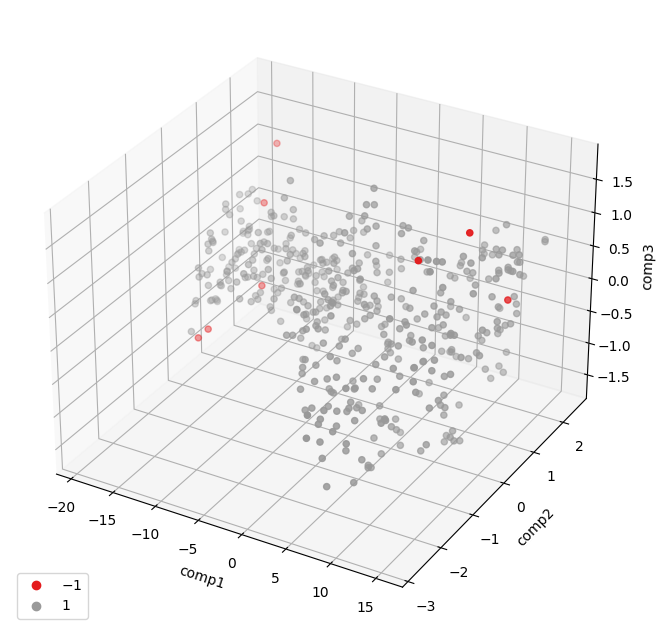

['catchta01w' 'chriska01w' 'crockwi01w' 'fordch01w' 'owenhe01w'
 'smithty01w' 'walkeay01w']
position: C


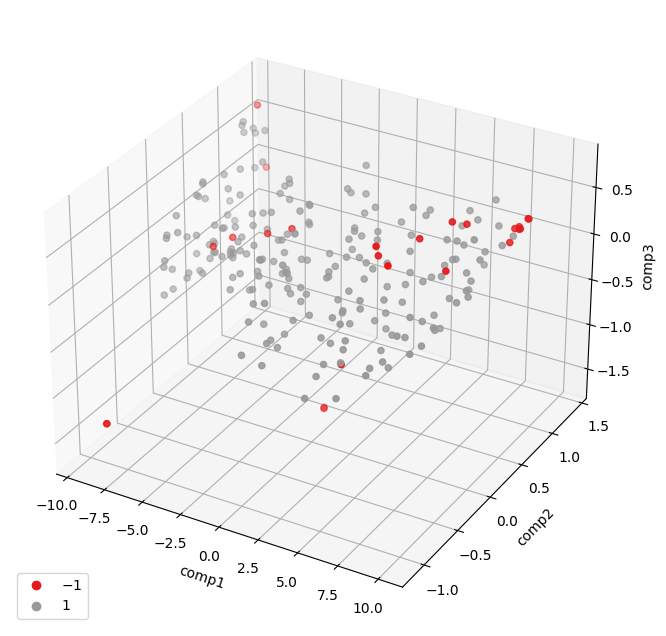

['adamsjo01w' 'batkosu01w' 'berezva01w' 'dydekma01w' 'leslili01w'
 'millebr01w' 'rileyru01w' 'sanniol01w' 'scottol01w' 'stepama01w'
 'walkema01w' 'wautean01w']
position: G


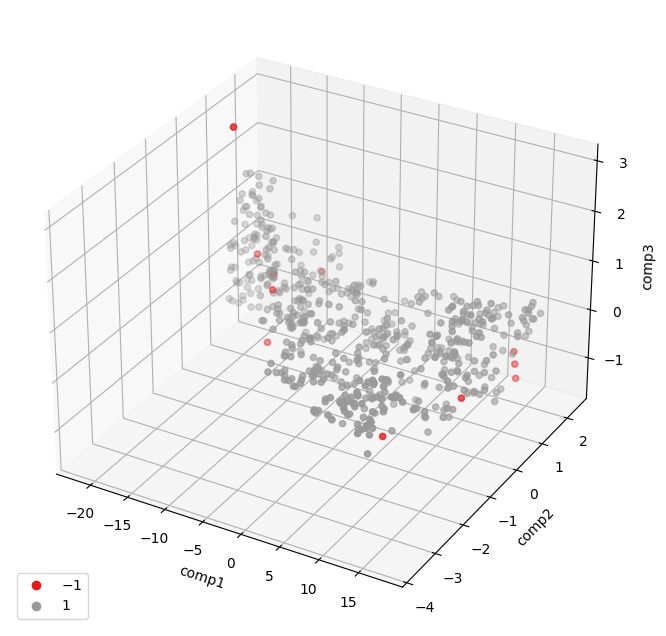

['bonnede01w' 'clinest01w' 'coopecy01w' 'davista02w' 'givench01w'
 'hornbal01w' 'payeka01w' 'timmsmi01w' 'wiggica01w' 'wrighta01w'
 'yamasli01w' 'zellosh01w']
position: F-G


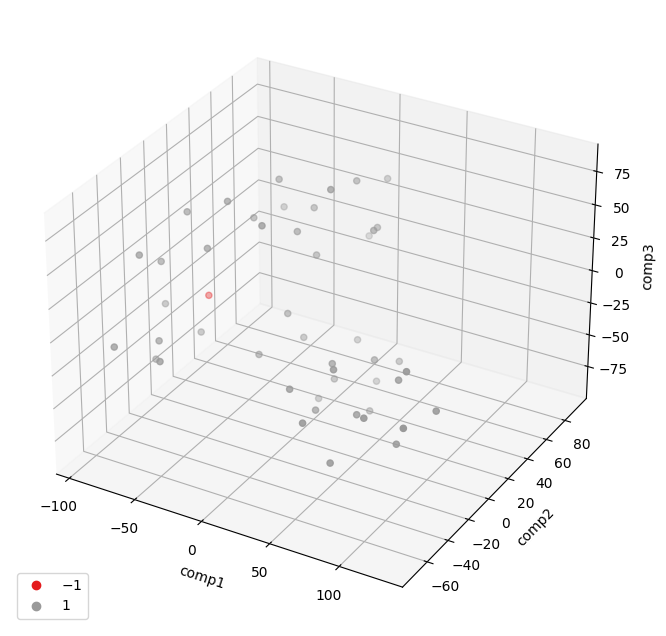

['tauradi01w']
position: G-F


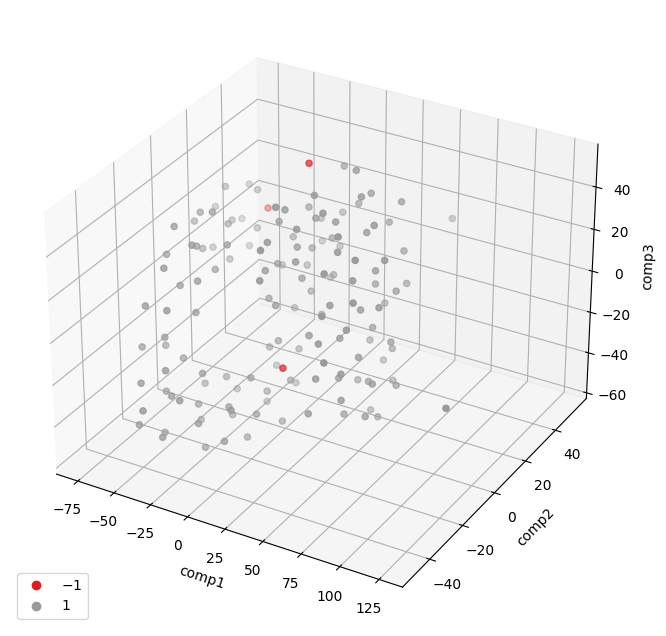

['atkinla01w' 'byearla01w']
position: F-C


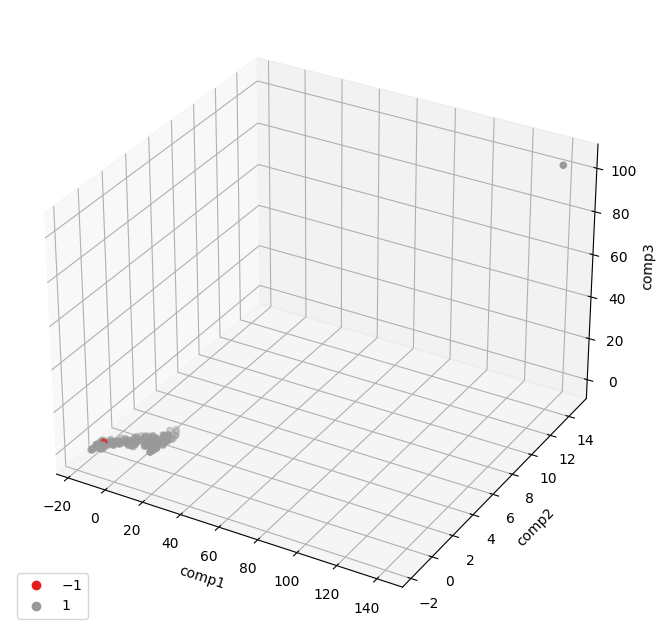

['lazicka01w']
position: C-F


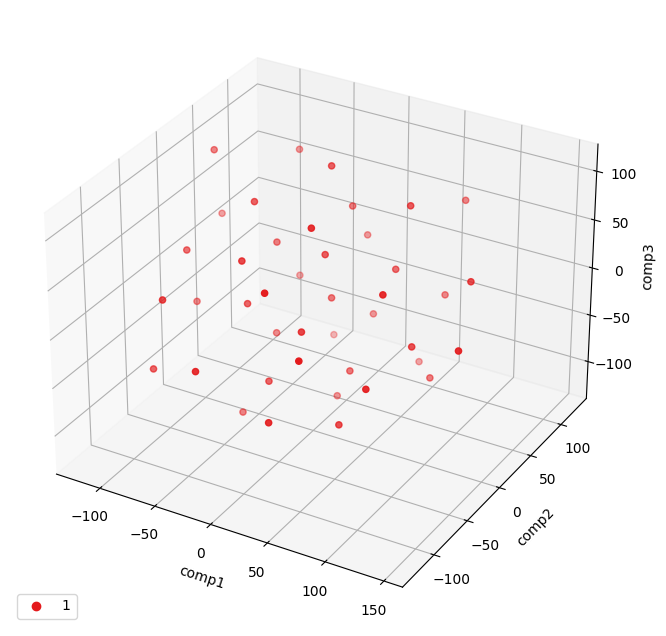

[]


,playerID,year,stint,tmID,TotalGP,Points,TotalMinutes,TotaloRebounds,TotaldRebounds,TotalRebounds,...,TotalftAttempted,TotalftMade,TotalthreeAttempted,TotalthreeMade,TotalGS,TotalDQ,pos,height,weight,outliers
0,abrossv01w,2,0,MIN,26,343,846,43,131,174,...,132,96,76,19,23,2,F,74.0,169,1
1,abrossv01w,3,0,MIN,27,314,805,45,101,146,...,116,56,60,20,27,0,F,74.0,169,1
2,abrossv01w,4,0,MIN,33,341,861,45,101,146,...,106,77,89,28,28,0,F,74.0,169,1
3,abrossv01w,5,0,MIN,24,166,529,20,63,83,...,50,30,61,22,13,0,F,74.0,169,1
4,abrossv01w,6,0,MIN,31,304,777,29,78,107,...,73,53,82,33,31,0,F,74.0,169,1
5,abrossv01w,7,0,MIN,34,263,724,44,62,106,...,62,41,65,24,2,0,F,74.0,169,1
6,abrossv01w,8,0,MIN,34,345,843,53,97,150,...,43,36,101,45,29,0,F,74.0,169,1
7,abrossv01w,9,0,CON,9,58,170,6,25,31,...,16,12,17,2,2,0,F,74.0,169,1
8,adamsjo01w,4,0,MIN,10,33,96,10,13,23,...,2,2,12,5,0,0,C,75.0,180,1
9,aguilel01w,3,0,UTA,30,43,145,0,11,11,...,7,4,21,11,0,0,G,67.0,165,1


In [240]:
unique_position = df_merged['pos'] 
unique_position = unique_position.drop_duplicates()

print(unique_position)

perp = [50,50,50,10,25,25,25]

perp_index = 0
for i in unique_position:
    df_i = df_merged[df_merged['pos'] == i]

    df_i = df_i.drop(['tmID', 'pos'], axis=1)

    df_i = df_i[df_i['stint'] == 0]


    x = df_i.iloc[:, 1:].values

    print(f"position: {i}")
    outliers = outliers_pipeline(x)
    df_i['outliers'] = outliers

    print_outliers_plot(x, outliers, perp=perp[perp_index])

    # print the outliers
    df_i = df_i[df_i['outliers'] == -1]
    df_i = df_i.drop(['outliers'], axis=1)
    print(df_i['playerID'].unique())

    perp_index += 1


df_merged.head(20)


In [241]:
# df_merged['PointsPerMin'] = df_merged['Points'].div(df_merged['TotalMinutes'])
# df_merged['oReboundsPerMin'] = df_merged['TotaloRebounds'].div(df_merged['TotalMinutes'])
# df_merged['dReboundsPerMin'] = df_merged['TotaldRebounds'].div(df_merged['TotalMinutes'])
# df_merged['ReboundsPerMin'] = df_merged['TotalRebounds'].div(df_merged['TotalMinutes'])
# df_merged['AssistsPerMin'] = df_merged['TotalAssists'].div(df_merged['TotalMinutes'])
# df_merged['StealsPerMin'] = df_merged['TotalSteals'].div(df_merged['TotalMinutes'])
# df_merged['BlocksPerMin'] = df_merged['TotalBlocks'].div(df_merged['TotalMinutes'])
# df_merged['TurnoversPerMin'] = df_merged['TotalTurnovers'].div(df_merged['TotalMinutes'])
# df_merged['PFPerMin'] = df_merged['TotalPF'].div(df_merged['TotalMinutes'])
# df_merged['fgAttemptedPerMin'] = df_merged['TotalfgAttempted'].div(df_merged['TotalMinutes'])
# df_merged['fgMadePerMin'] = df_merged['TotalfgMade'].div(df_merged['TotalMinutes'])
# df_merged['ftAttemptedPerMin'] = df_merged['TotalftAttempted'].div(df_merged['TotalMinutes'])
# df_merged['ftMadePerMin'] = df_merged['TotalftMade'].div(df_merged['TotalMinutes'])
# df_merged['threeAttemptedPerMin'] = df_merged['TotalthreeAttempted'].div(df_merged['TotalMinutes'])
# df_merged['threeMadePerMin'] = df_merged['TotalthreeMade'].div(df_merged['TotalMinutes'])
# 
# df_merged.fillna(0, inplace=True)
## Existe um problema com esta abordagem, jogadores que jogaram pouco mas bem podem ter uma vantagem ... TODO: testar com isto

df_merged = df_merged.groupby(['playerID', 'year']).agg({
    'Points': 'sum',
    'TotalMinutes': 'sum',
    'TotaloRebounds': 'sum',
    'TotaldRebounds': 'sum',
    'TotalRebounds': 'sum',
    'TotalAssists': 'sum',
    'TotalSteals': 'sum',
    'TotalBlocks': 'sum',
    'TotalTurnovers': 'sum',
    'TotalPF': 'sum',
    'TotalfgAttempted': 'sum',
    'TotalfgMade': 'sum',
    'TotalftAttempted': 'sum',
    'TotalftMade': 'sum',
    'TotalthreeAttempted': 'sum',
    'TotalthreeMade': 'sum',
    'TotalGP': 'sum'
})

df_merged = df_merged.reset_index()


#group by year and player
df_merged = df_merged.groupby(['playerID']).agg({
    'Points': 'mean',
    'TotalMinutes': 'mean',
    'TotaloRebounds': 'mean',
    'TotaldRebounds': 'mean',
    'TotalRebounds': 'mean',
    'TotalAssists': 'mean',
    'TotalSteals': 'mean',
    'TotalBlocks': 'mean',
    'TotalTurnovers': 'mean',
    'TotalPF': 'mean',
    'TotalfgAttempted': 'mean',
    'TotalfgMade': 'mean',
    'TotalftAttempted': 'mean',
    'TotalftMade': 'mean',
    'TotalthreeAttempted': 'mean',
    'TotalthreeMade': 'mean',
    'TotalGP': 'mean'
})
df_merged = df_merged.reset_index()


#todo: tirar de cima isto
df_merged = df_merged.drop(['TotalMinutes','TotalGP'], axis=1)

players_id = df_merged['playerID']
df_merged.head()


,playerID,Points,TotaloRebounds,TotaldRebounds,TotalRebounds,TotalAssists,TotalSteals,TotalBlocks,TotalTurnovers,TotalPF,TotalfgAttempted,TotalfgMade,TotalftAttempted,TotalftMade,TotalthreeAttempted,TotalthreeMade
0,abrossv01w,266.75,35.625,82.25,117.875,57.75,37.625,5.75,68.0,67.25,244.125,96.25,74.75,50.125,68.875,24.125
1,adamsjo01w,33.00,10.000,13.00,23.000,4.00,2.000,3.00,10.0,10.00,33.000,13.00,2.00,2.000,12.000,5.000
2,aguilel01w,43.00,0.000,11.00,11.000,18.00,3.000,2.00,11.0,6.00,33.000,14.00,7.00,4.000,21.000,11.000
3,ajavoma01w,282.00,30.500,34.00,64.500,49.50,36.000,5.00,53.5,87.50,276.500,92.50,103.50,75.500,79.000,21.500
4,aldrima01w,42.00,5.500,9.50,15.000,18.50,5.000,2.00,16.0,19.00,37.000,16.50,15.50,6.000,9.000,3.000


In [242]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# drop all non numerical atributes
df_merged = df_merged.select_dtypes(include=['float64', 'int64'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged)

df_merged = pandas.DataFrame(X_scaled, columns=df_merged.columns)


df_merged['medium'] = df_merged.mean(axis=1) # TODO: make this not by year but by player years performance


Y_ = df_merged['medium'] 

gb_model.fit(X_scaled, Y_)

y_pred = gb_model.predict(X_scaled)

mse = mean_squared_error(Y_, y_pred)

# add player Id back and print the predictions for each row
df_merged['playerID'] = players_id
df_merged['predictions'] = y_pred
df_merged['medium'] = Y_

# drop all atributes exept playerID, medium and predictions
df_pred = df_merged[['playerID', 'medium', 'predictions']]


# print the 5 most rated players
df_pred = df_pred.sort_values(by=['medium'], ascending=False)
df_pred.head(10)



,playerID,medium,predictions
464,tauradi01w,3.357231,3.336905
275,leslili01w,3.303227,3.294452
86,catchta01w,3.170157,3.164172
368,parkeca01w,2.888040,2.885868
228,jacksla01w,2.698630,2.707898
379,pondeca01w,2.622344,2.642727
548,youngso01w,2.315050,2.360242
434,smithka01w,2.208483,2.196639
35,beardal01w,2.199414,2.206995
475,thompti01w,2.129342,2.120975
